In [1]:
import os
import mc
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.api as sm
from patsy import dmatrices, build_design_matrices


In [3]:
def get_data(sub, trials):
    data_folder = "/Users/xpsy1114/Documents/projects/multiple_clocks/data/ephys_humans/derivatives"
    if not os.path.isdir(data_folder):
        print("running on ceph")
        data_folder = "/ceph/behrens/svenja/human_ABCD_ephys/derivatives"
    if trials == 'residualised':
        res_data = True
    else:
        res_data = False
    data_norm = mc.analyse.helpers_human_cells.load_norm_data(data_folder, [f"{sub:02}"], res_data = res_data)
    return data_norm, data_folder 

In [8]:
def plot_roi_state_repeat_estimate(d_roi, roi_name):
    d_roi = d_roi.dropna(subset=["y","state","repeat","neuron_id"]).copy()
    d_roi["state"] = pd.Categorical(d_roi["state"], ["A","B","C","D"], ordered=True)
    d_roi["repeat_c"] = d_roi["repeat"] - d_roi["repeat"].mean()

    # Build design so rows used are explicit
    y, X = dmatrices("y ~ C(state) * repeat_c", d_roi, return_type="dataframe")
    groups = d_roi.loc[y.index, "neuron_id"].to_numpy()

    # OLS with cluster-robust SEs (by neuron)
    res = sm.OLS(y, X).fit(cov_type="cluster", cov_kwds={"groups": groups})

    # Prediction grid (1..10 repeats, all states), with same design columns
    reps = np.arange(1, 11)
    grid = pd.DataFrame([(s, r, r - d_roi["repeat"].mean())
                         for s in ["A","B","C","D"] for r in reps],
                        columns=["state","repeat","repeat_c"])
    Xg = build_design_matrices([X.design_info], grid)[0]
    Xg = np.asarray(Xg)
    beta = res.params.values
    cov  = res.cov_params().values

    yhat = Xg @ beta
    se   = np.sqrt(np.einsum("ij,jk,ik->i", Xg, cov, Xg))   # diag(Xg cov Xg^T)
    grid["y_hat"] = yhat
    grid["lo"] = yhat - 1.96*se
    grid["hi"] = yhat + 1.96*se

    # Plot
    plt.figure(figsize=(7,4))
    for s in ["A","B","C","D"]:
        g = grid[grid["state"] == s]
        plt.plot(g["repeat"], g["y_hat"], marker="o", label=s)
        plt.fill_between(g["repeat"], g["lo"], g["hi"], alpha=0.15)
    plt.axhline(0, ls="--", lw=1)
    plt.title(f"{roi_name}: modelled state profiles across repeats")
    plt.xlabel("Repeat"); plt.ylabel("Predicted response")
    plt.legend(title="State"); plt.tight_layout(); plt.show()

    # Strongest state per repeat (based on model predictions)
    wide = grid.pivot(index="repeat", columns="state", values="y_hat")
    strongest = wide.idxmax(axis=1)
    print(f"\n{roi_name} — strongest state per repeat (model predictions):")
    print(strongest.to_string())
    return res, grid

In [9]:
def plot_wta_proportions(d_roi, roi_name):
    d = d_roi.dropna(subset=["y","state","repeat","neuron_id"]).copy()
    d["state"] = pd.Categorical(d["state"], ["A","B","C","D"], ordered=True)

    # neuron-level means per state×repeat
    dn = d.groupby(["neuron_id","state","repeat"])["y"].mean().reset_index()
    # pivot to states as columns; some neurons may miss a state→dropna row-wise
    mat = dn.pivot_table(index=["neuron_id","repeat"], columns="state", values="y")
    mat = mat.dropna(how="any")  # keep rows with all 4 states present

    winner = mat.idxmax(axis=1)   # state label per (neuron, repeat)
    prop = (winner.groupby(level="repeat")
                  .value_counts(normalize=True)
                  .unstack(fill_value=0)
                  .reindex(columns=["A","B","C","D"], fill_value=0))

    plt.figure(figsize=(7,4))
    for s in ["A","B","C","D"]:
        plt.plot(prop.index, prop[s], marker="o", label=s)
    plt.ylim(0,1)
    plt.title(f"{roi_name}: proportion of neurons preferring each state")
    plt.xlabel("Repeat"); plt.ylabel("Proportion of neurons")
    plt.legend(title="State"); plt.tight_layout(); plt.show()

    print(f"\n{roi_name} — WTA proportions (head):")
    print(prop.head())

In [10]:
def plot_fit_vs_raw_for_roi(d_roi, roi_name):
    # tidy + center
    d = d_roi.dropna(subset=["y","state","repeat","neuron_id"]).copy()
    d["state"]  = pd.Categorical(d["state"], ["A","B","C","D"], ordered=True)
    d["repeat_c"] = d["repeat"] - d["repeat"].mean()

    # design + cluster ids
    y, X = dmatrices("y ~ C(state) * repeat_c", d, return_type="dataframe")
    groups = d.loc[y.index, "neuron_id"].to_numpy()

    # fit once (cluster-robust by neuron)
    res = sm.OLS(y, X).fit(cov_type="cluster", cov_kwds={"groups": groups})

    # --- MODEL PREDICTIONS + CIs ---
    reps = np.arange(0,10)
    grid = pd.DataFrame([(s, r, r - d["repeat"].mean())
                         for s in ["A","B","C","D"] for r in reps],
                        columns=["state","repeat","repeat_c"])
    Xg = np.asarray(build_design_matrices([X.design_info], grid)[0])
    beta = res.params.values
    cov  = res.cov_params().values
    yhat = Xg @ beta
    se   = np.sqrt(np.einsum("ij,jk,ik->i", Xg, cov, Xg))

    grid["y_hat"] = yhat
    grid["lo"]    = yhat - 1.96*se
    grid["hi"]    = yhat + 1.96*se

    # --- RAW: neuron-level means then mean±SEM across neurons ---
    # collapse to one value per neuron x state x repeat
    dn = (d.groupby(["neuron_id","state","repeat"])["y"]
            .mean().reset_index())
    raw_mean = dn.groupby(["state","repeat"])["y"].mean().reset_index(name="raw_mean")
    raw_sem  = dn.groupby(["state","repeat"])["y"].sem().reset_index(name="raw_sem")
    raw = pd.merge(raw_mean, raw_sem, on=["state","repeat"], how="left")

    # --- PLOT ---
    plt.figure(figsize=(7,4))
    for s in ["A","B","C","D"]:
        g = grid[grid["state"]==s]
        r = raw [raw ["state"]==s]
        # model line + 95% CI
        plt.plot(g["repeat"], g["y_hat"], marker="o", label=f"{s} (model)")
        plt.fill_between(g["repeat"], g["lo"], g["hi"], alpha=0.15)
        # raw mean±SEM as ribbon only (or change to errorbars if you prefer)
        plt.fill_between(r["repeat"], r["raw_mean"]-r["raw_sem"], r["raw_mean"]+r["raw_sem"], alpha=0.30)
    plt.axhline(0, ls="--", lw=1)
    plt.title(f"{roi_name}: model vs raw")
    plt.xlabel("Repeat"); plt.ylabel("Response")
    plt.legend(title="State"); plt.tight_layout(); plt.show()   

    return res, grid, raw

In [6]:
sessions=list(range(0,64))
trials = 'all_minus_explore'
sparsity_c = 'gridwise_qc'
save_all=True
only_BCD = False

# first step: call long table, otherwise
sesh = sessions[1]
# load data
data_raw, source_dir = get_data(sesh, trials=trials)
group_dir_state = f"{source_dir}/group/state_tuning"

print(f"this is the folder {group_dir_state}")

loading files for subject 01
this is the folder /Users/xpsy1114/Documents/projects/multiple_clocks/data/ephys_humans/derivatives/group/state_tuning


In [20]:
# load the data to one huge df
# to make it more readable/ easier to plot:
# df has one mean value per repeat/ state (4 bins)/ task/ neuron
# df_ph has one mean value per repeat/ phase-state (12 bins)/ task/ neuron


if not os.path.isfile(f"{group_dir_state}/avg_state_long_table.csv"):
    # create a long table of all neurons, that contains what I want to model:
        
    # subject (ID)
    # neuron (unique ID; e.g., "S12_N034")
    # ROI (hippocampus / EC / ACC / …)
    # task (label)
    # repeat (1–10)
    # state (A/B/C/D)
    # y (the response you want to model)
    
    # boundaries for A,B,C,D within 360 timepoints
    
    state_bins = {"A": slice(0, 90), "B": slice(90, 180), "C": slice(180, 270), "D": slice(270, 360)}
    
    phase_bins = {"A_early": slice(0, 30), "A_mid": slice(30, 60),"A_rew": slice(60, 90), 
                  "B_early": slice(90, 120), "B_mid": slice(120, 150),"B_rew": slice(150, 180),
                  "C_early": slice(180, 210),"C_mid": slice(210, 240),"C_rew": slice(240, 270),
                  "D_early": slice(270, 300),"D_mid": slice(300, 330),"D_rew": slice(330, 360)}
    

    
    
    
    rows = []
    rows_phase = []
    for sesh in sessions:
        # load data
        data_raw, source_dir = get_data(sesh, trials=trials)
        group_dir_state = f"{source_dir}/group/state_tuning"
        # import pdb; pdb.set_trace()
        # if this session doesn't exist, skip
        if not data_raw:
            print(f"no raw data found for {sesh}, so skipping")
            continue
    
        # filter data for only those repeats that were 1) correct and 2) not the first one
        data = mc.analyse.helpers_human_cells.filter_data(data_raw, sesh, trials)
        beh_df = data[f"sub-{sesh:02}"]['beh'].copy()
        
        # clean each neuron such that you only consider the repeats that are reliable
        for neuron_idx, curr_neuron in enumerate(data[f"sub-{sesh:02}"]['normalised_neurons']):
            print(f"adding neuron {curr_neuron}")
            # resetting unique tasks for each neuron.
            # determine identical grids
            grid_cols = ['loc_A', 'loc_B', 'loc_C', 'loc_D']
            unique_grids, _, idx_same_grids, _ = np.unique(
                beh_df[grid_cols].to_numpy(),
                axis=0,
                return_index=True,
                return_inverse=True,
                return_counts=True
            )
        
            beh_df['idx_same_grids'] = idx_same_grids
    
            # clean the data such that I don't consider 'bad' blocks of repeats
            # with super low firing 
            if sparsity_c:
                beh_df = mc.analyse.helpers_human_cells.extract_consistent_grids(data[f"sub-{sesh:02}"]['normalised_neurons'][curr_neuron].to_numpy(), curr_neuron, beh_df)
                consistent_grids_mask = beh_df[f'consistent_FR_{curr_neuron}'].to_numpy()
                # set grid indexes I want to ignore to -1
                idx_same_grids[~consistent_grids_mask] = -1
                
                # if after excluding inconsistent grids there aren't enough grids for CV left,
                # kick this neuron.
                unique_grids = np.unique(beh_df['idx_same_grids'][beh_df[f'consistent_FR_{curr_neuron}']])
            
            if sparsity_c and len(unique_grids) < 3:
                print(f"excluding {curr_neuron} in sesh {sesh} because there were not enough grids with consistent FR!")
                continue
            
            # based on the cleaned behaviour, store the average value per state.
            for count_task, task_id in enumerate(unique_grids):
                mask_task = (idx_same_grids == task_id)
                neuron_curr_task = data[f"sub-{sesh:02}"]['normalised_neurons'][curr_neuron].loc[mask_task].to_numpy()
                # first z-score the neuron within task
                neuron_curr_task = (neuron_curr_task - neuron_curr_task.mean()) / neuron_curr_task.std(ddof=1)
                beh_curr_task = beh_df[mask_task]
                
                for corr_rep in range(0,10):
                    # import pdb; pdb.set_trace()  
                    mask_rep = (beh_curr_task['rep_correct'].isin([corr_rep])& beh_curr_task['correct']== 1)
                    neuron_curr_task_curr_rep = np.mean(neuron_curr_task[mask_rep], axis =0)
                    #roi
                    for s, st_bins in state_bins.items():
                        rows.append({
                            "subject": sesh,
                            "neuron_id": f"{sesh}_{curr_neuron}",
                            "task": f"task_{task_id}",
                            "repeat": corr_rep,
                            "state": s,
                            "y": float(np.mean(neuron_curr_task_curr_rep[st_bins]))
                        })
                    for ph, ph_bins in phase_bins.items():
                        rows_phase.append({
                            "subject": sesh,
                            "neuron_id": f"{sesh}_{curr_neuron}",
                            "task": f"task_{task_id}",
                            "repeat": corr_rep,
                            "phase": ph,
                            "y": float(np.mean(neuron_curr_task_curr_rep[ph_bins]))
                            })
 
    
    df = pd.DataFrame(rows)
    
    df["state"] = pd.Categorical(df["state"], ["A","B","C","D"], ordered=True)
    df["repeat_c"] = df["repeat"] - df["repeat"].mean()
    df['roi']= mc.analyse.helpers_human_cells.rename_rois(df,collapse_pfc=False,plot_by_cingulate_and_MTL=False)
    df["roi"] = df["roi"].astype("category")
                
    # store the df so you don't always need to regenerate.
    df.to_csv(f"{group_dir_state}/avg_state_long_table.csv")         
    
     
    
    
    df_ph = pd.DataFrame(rows_phase)
    
    df_ph["phase"] = pd.Categorical(df_ph["phase"], ["A_early", "A_mid", "A_rew",
                                                  "B_early", "B_mid", "B_rew",
                                                  "C_early", "C_mid", "C_rew",
                                                  "D_early", "D_mid", "D_rew"], ordered=True)
    
    df_ph["repeat_c"] = df["repeat"] - df["repeat"].mean()
    df_ph['roi']= mc.analyse.helpers_human_cells.rename_rois(df_ph,collapse_pfc=False,plot_by_cingulate_and_MTL=False)
    df_ph["roi"] = df["roi"].astype("category")
    # store the df so you don't always need to regenerate.
    df_ph.to_csv(f"{group_dir_state}/avg_phase-state_long_table.csv")         

else:
    df_ph = pd.read_csv(f"{group_dir_state}/avg_phase-state_long_table.csv")
    df = pd.read_csv(f"{group_dir_state}/avg_state_long_table.csv")
       

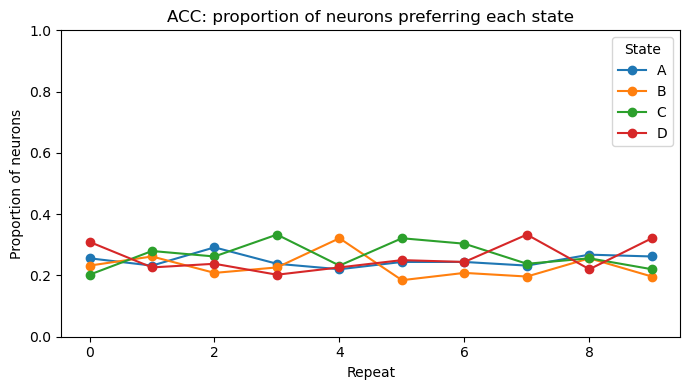


ACC — WTA proportions (head):
               A         B         C         D
repeat                                        
0       0.255952  0.232143  0.202381  0.309524
1       0.232143  0.261905  0.279762  0.226190
2       0.291667  0.208333  0.261905  0.238095
3       0.238095  0.226190  0.333333  0.202381
4       0.220238  0.321429  0.232143  0.226190


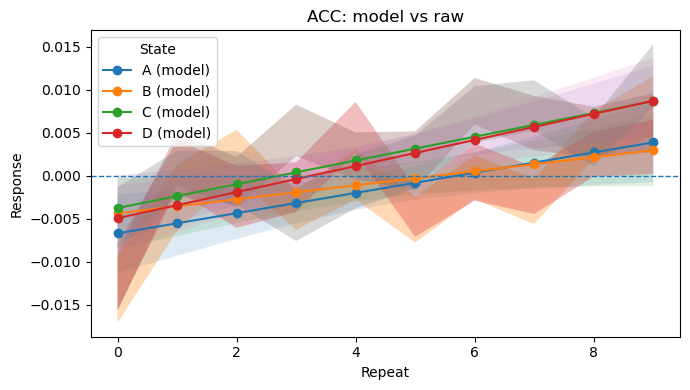

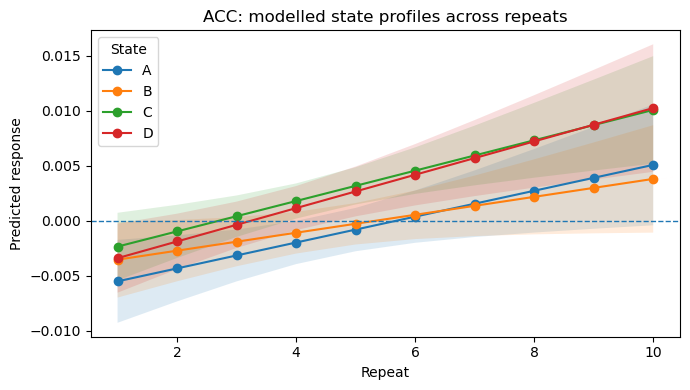


ACC — strongest state per repeat (model predictions):
repeat
1     C
2     C
3     C
4     C
5     C
6     C
7     C
8     C
9     D
10    D


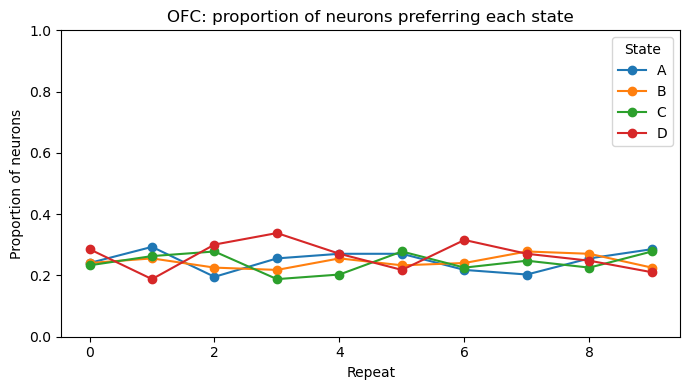


OFC — WTA proportions (head):
               A         B         C         D
repeat                                        
0       0.240602  0.240602  0.233083  0.285714
1       0.293233  0.255639  0.263158  0.187970
2       0.195489  0.225564  0.278195  0.300752
3       0.255639  0.218045  0.187970  0.338346
4       0.270677  0.255639  0.203008  0.270677


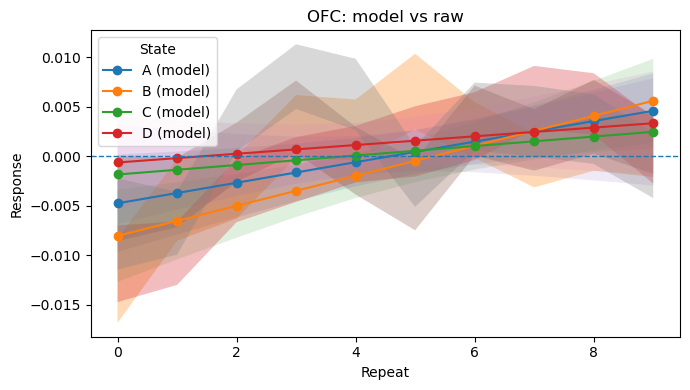

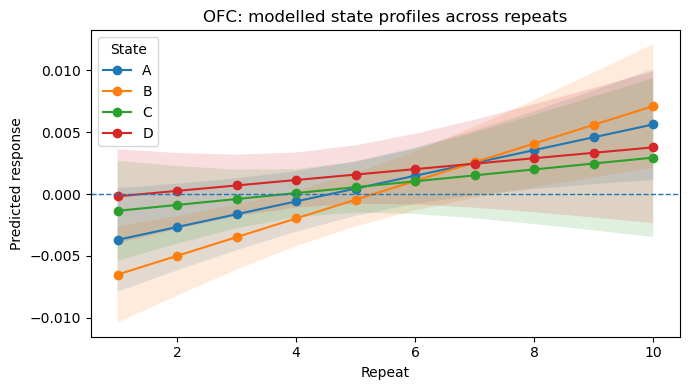


OFC — strongest state per repeat (model predictions):
repeat
1     D
2     D
3     D
4     D
5     D
6     D
7     B
8     B
9     B
10    B


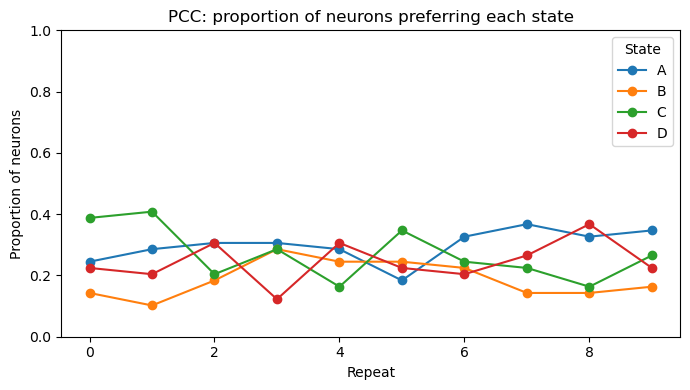


PCC — WTA proportions (head):
               A         B         C         D
repeat                                        
0       0.244898  0.142857  0.387755  0.224490
1       0.285714  0.102041  0.408163  0.204082
2       0.306122  0.183673  0.204082  0.306122
3       0.306122  0.285714  0.285714  0.122449
4       0.285714  0.244898  0.163265  0.306122


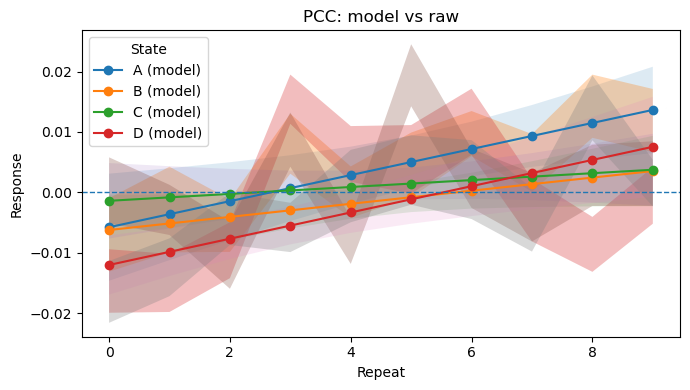

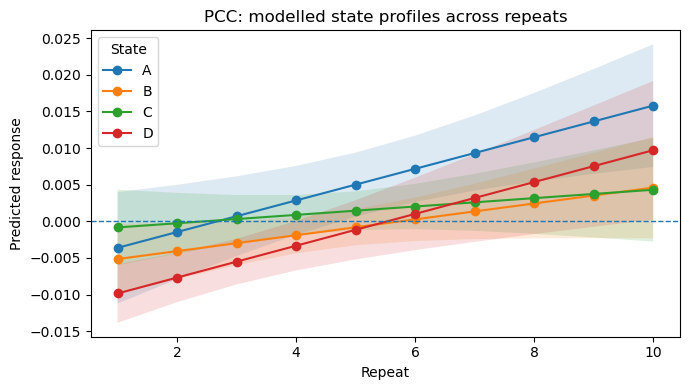


PCC — strongest state per repeat (model predictions):
repeat
1     C
2     C
3     A
4     A
5     A
6     A
7     A
8     A
9     A
10    A


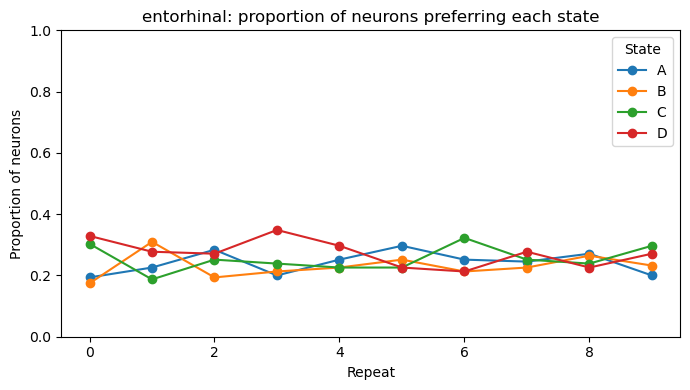


entorhinal — WTA proportions (head):
               A         B         C         D
repeat                                        
0       0.193548  0.174194  0.303226  0.329032
1       0.225806  0.309677  0.187097  0.277419
2       0.283871  0.193548  0.251613  0.270968
3       0.200000  0.212903  0.238710  0.348387
4       0.251613  0.225806  0.225806  0.296774


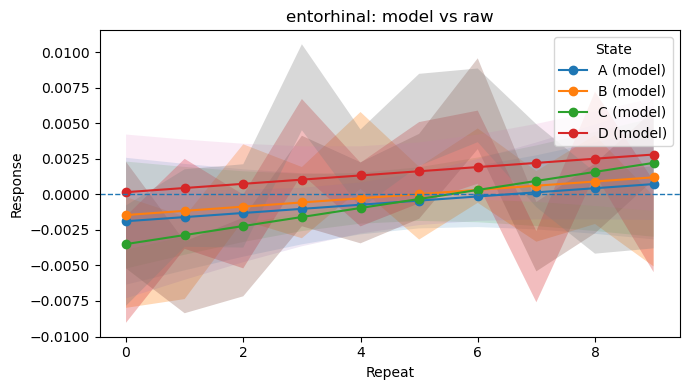

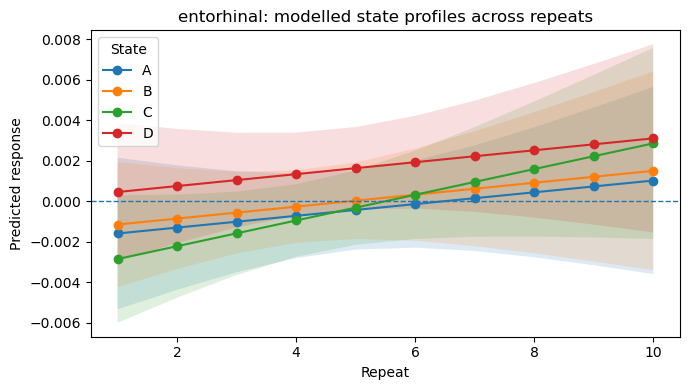


entorhinal — strongest state per repeat (model predictions):
repeat
1     D
2     D
3     D
4     D
5     D
6     D
7     D
8     D
9     D
10    D


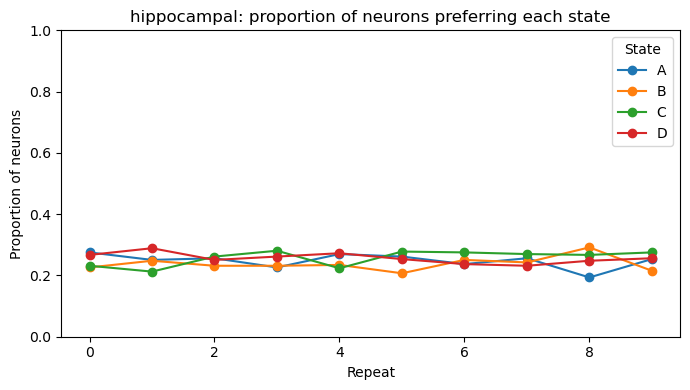


hippocampal — WTA proportions (head):
               A         B         C         D
repeat                                        
0       0.275204  0.226158  0.231608  0.267030
1       0.250681  0.247956  0.212534  0.288828
2       0.256131  0.231608  0.261580  0.250681
3       0.226158  0.231608  0.280654  0.261580
4       0.269755  0.234332  0.223433  0.272480


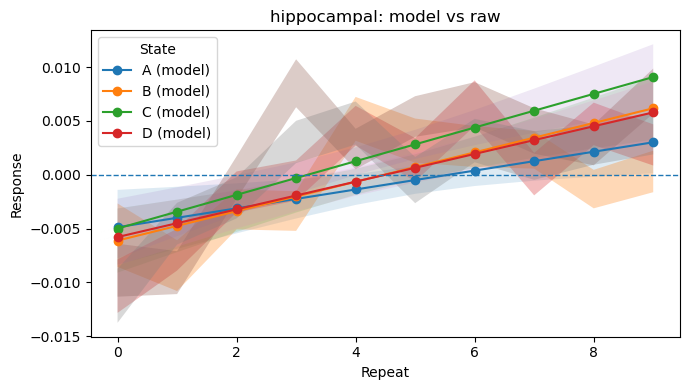

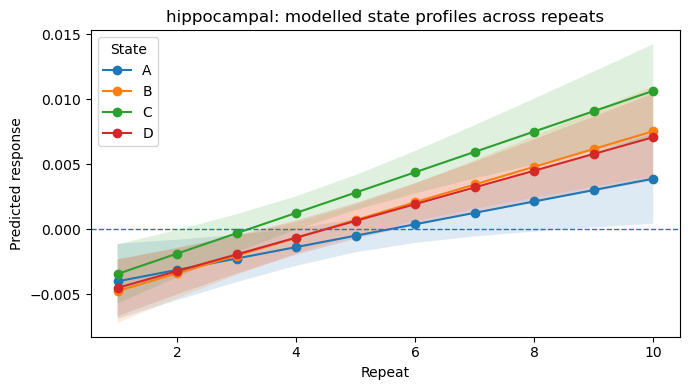


hippocampal — strongest state per repeat (model predictions):
repeat
1     C
2     C
3     C
4     C
5     C
6     C
7     C
8     C
9     C
10    C


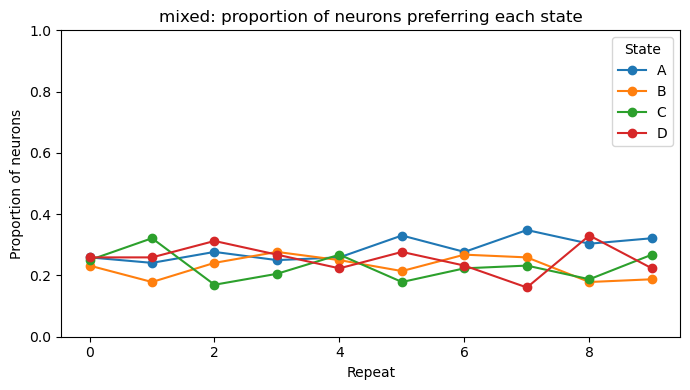


mixed — WTA proportions (head):
               A         B         C         D
repeat                                        
0       0.258929  0.232143  0.250000  0.258929
1       0.241071  0.178571  0.321429  0.258929
2       0.276786  0.241071  0.169643  0.312500
3       0.250000  0.276786  0.205357  0.267857
4       0.258929  0.250000  0.267857  0.223214


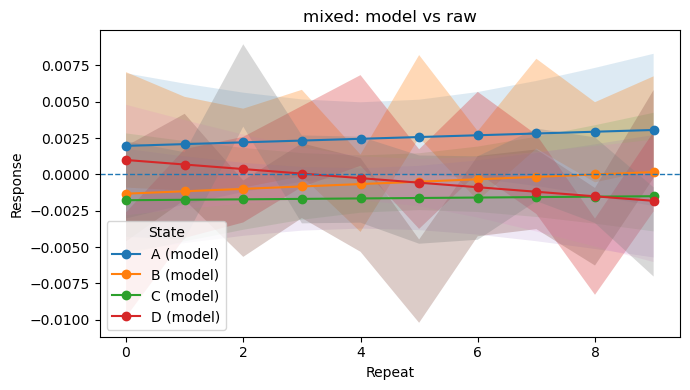

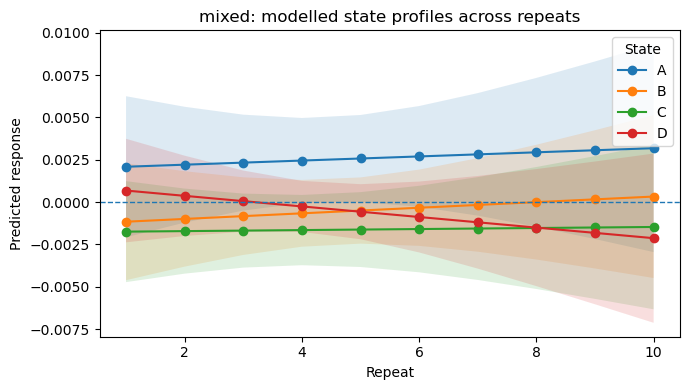


mixed — strongest state per repeat (model predictions):
repeat
1     A
2     A
3     A
4     A
5     A
6     A
7     A
8     A
9     A
10    A


In [16]:
# use per ROI
for roi, d_roi in df.groupby("roi"):
    plot_wta_proportions(d_roi, roi)
    res, grid, raw = plot_fit_vs_raw_for_roi(d_roi, roi)
    res_e, grid_e = plot_roi_state_repeat_estimate(d_roi, roi)
    

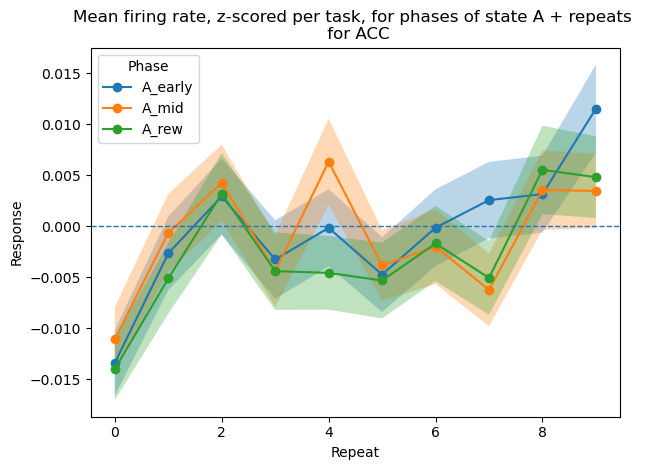

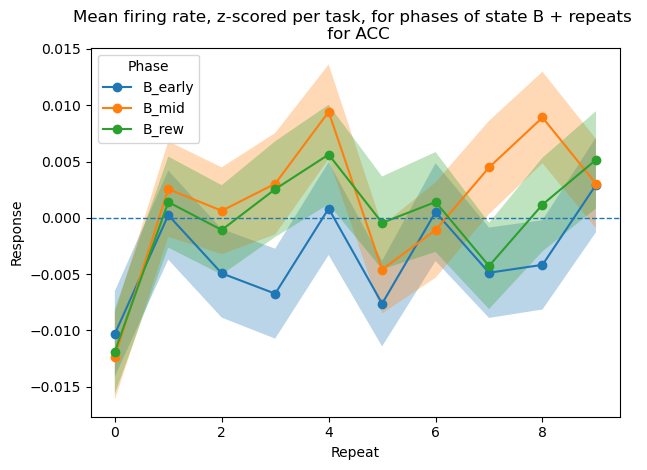

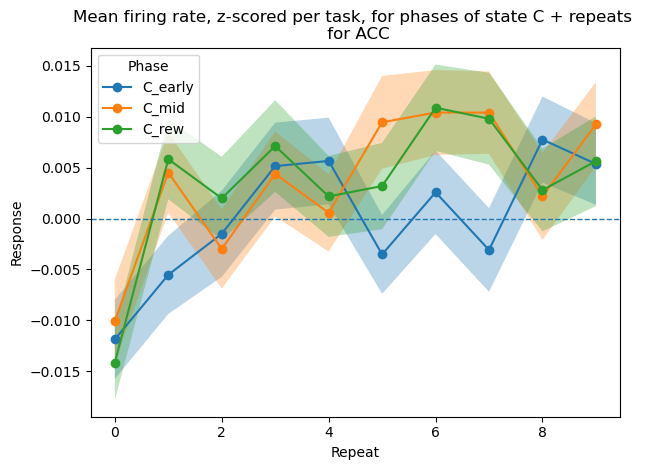

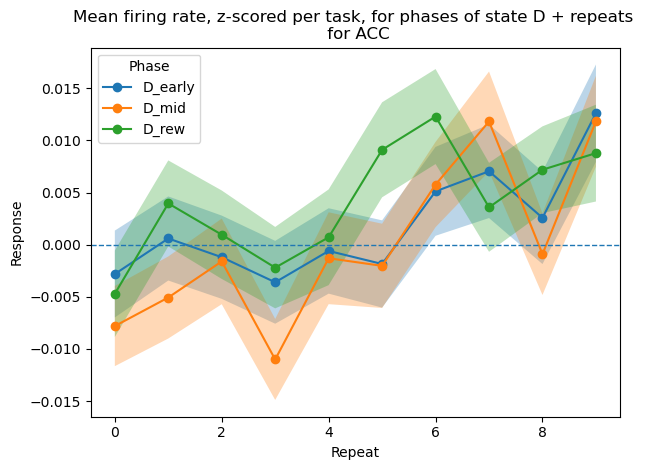

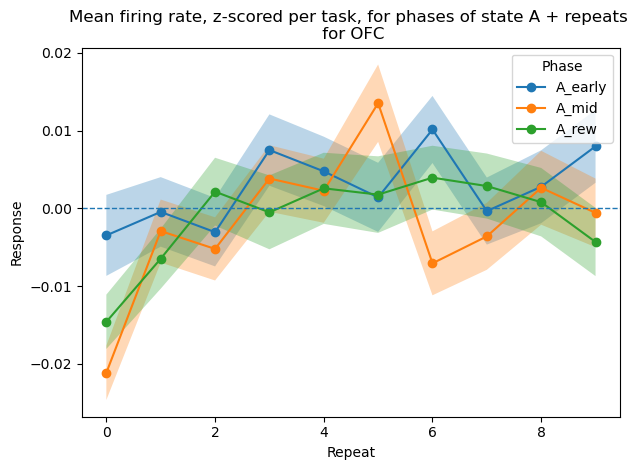

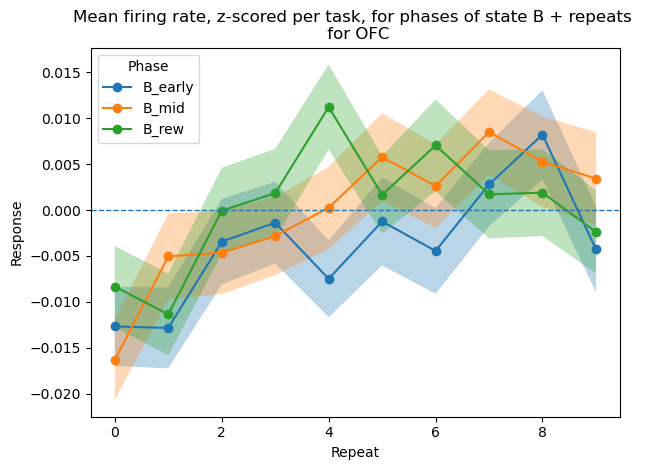

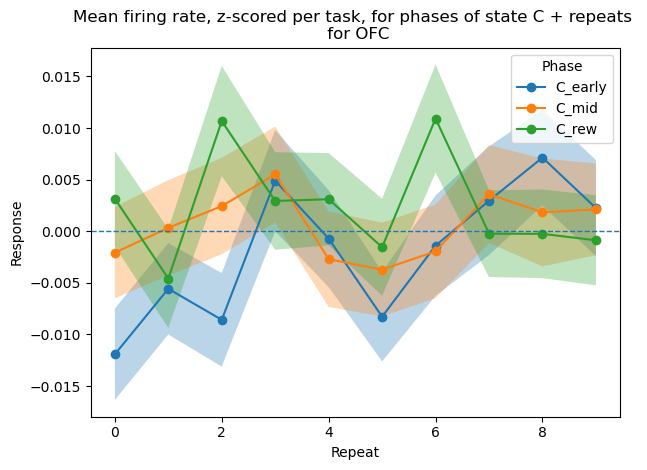

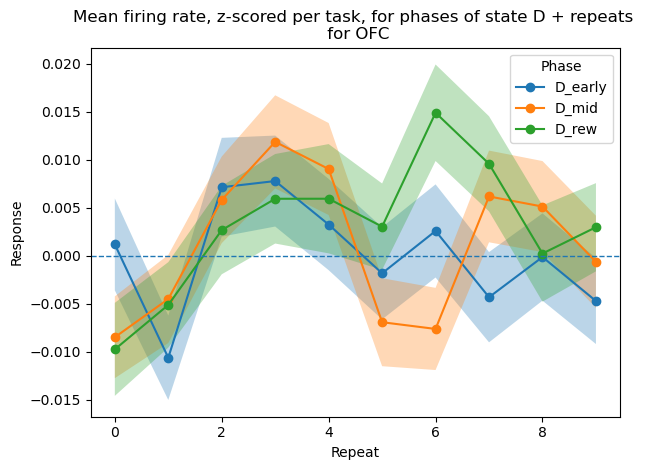

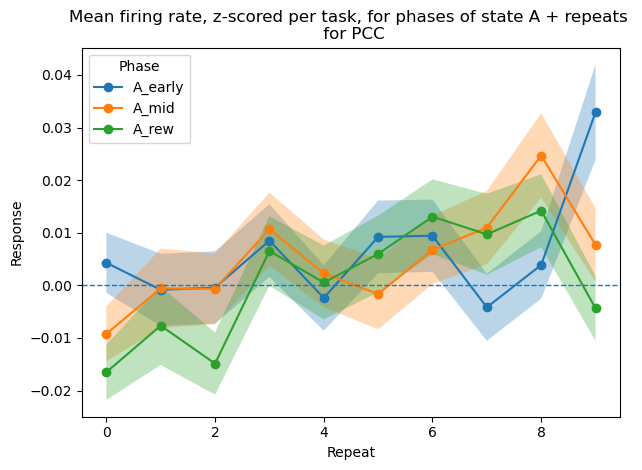

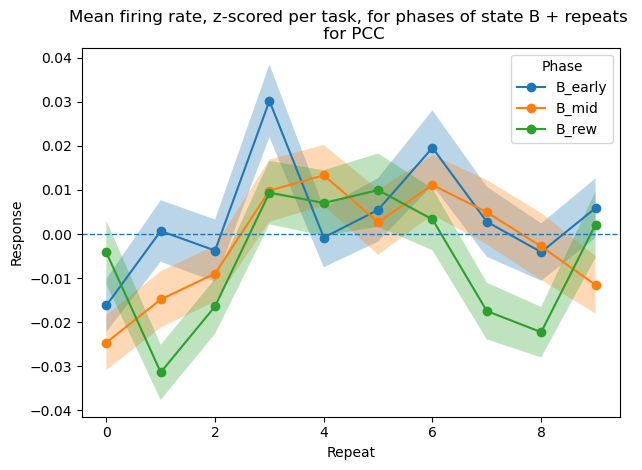

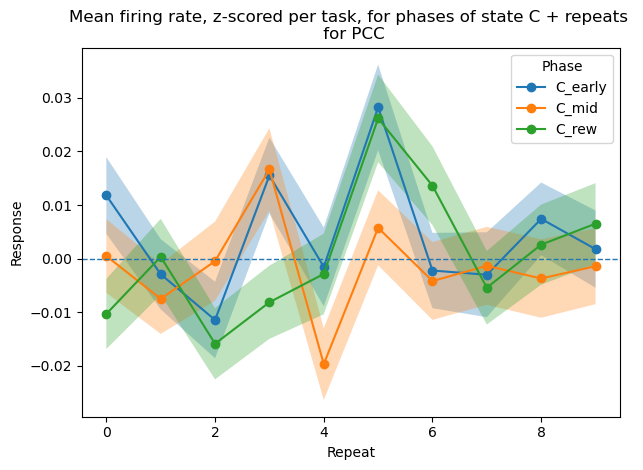

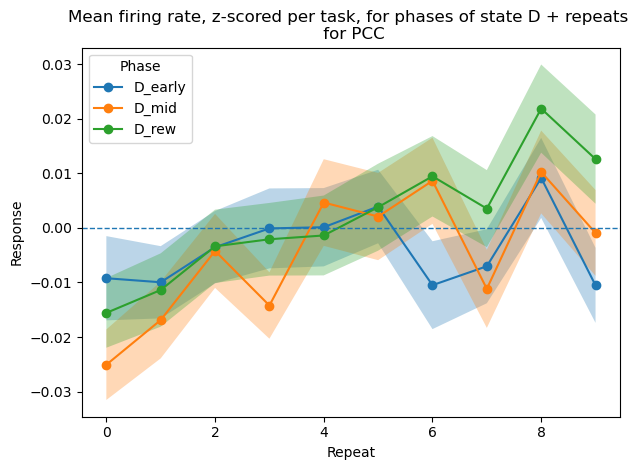

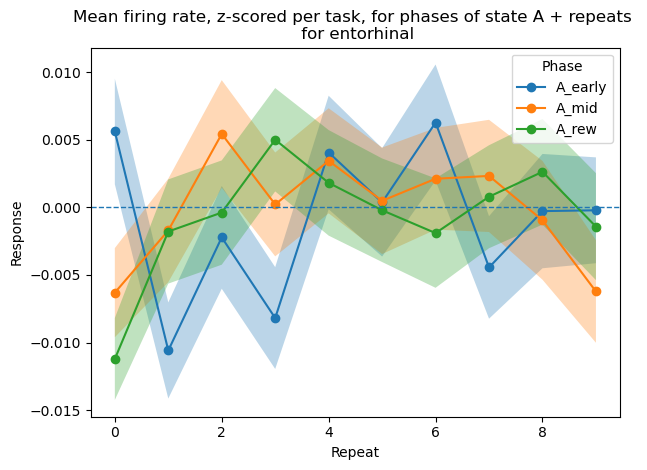

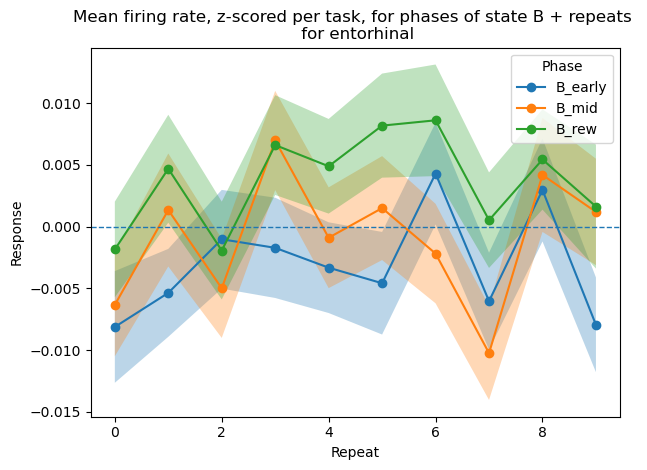

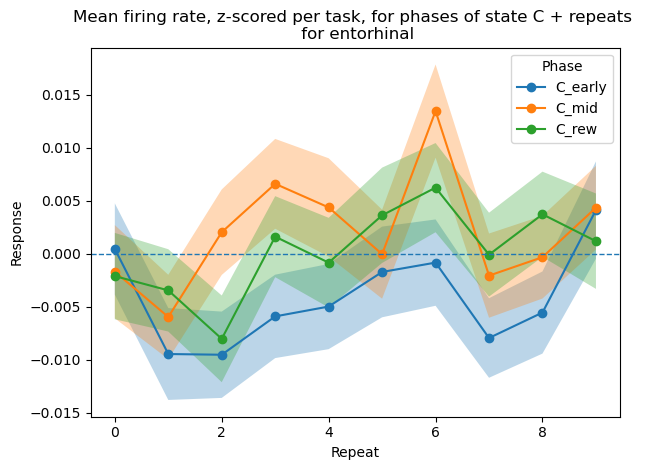

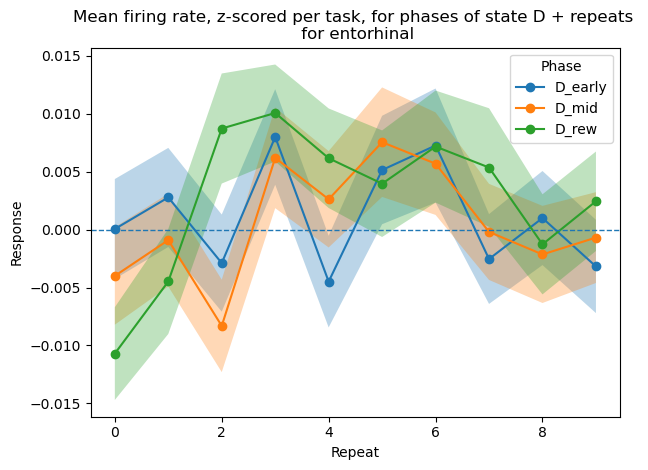

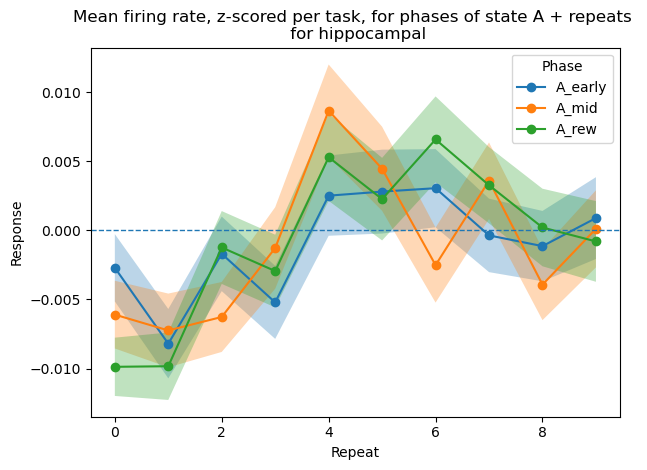

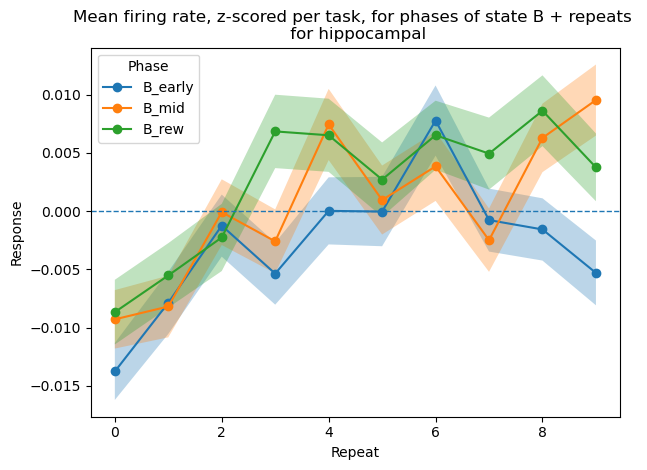

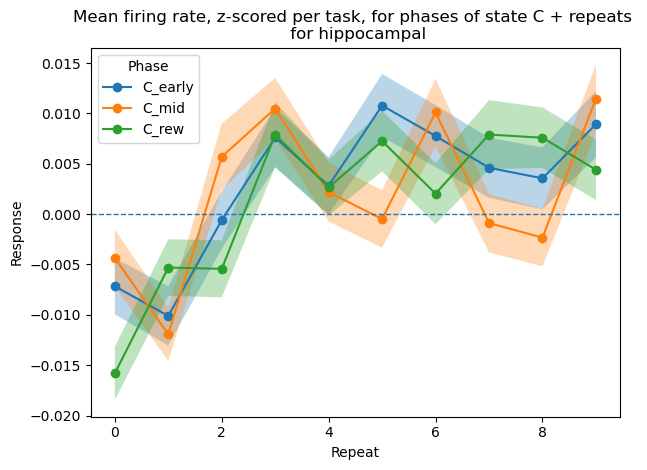

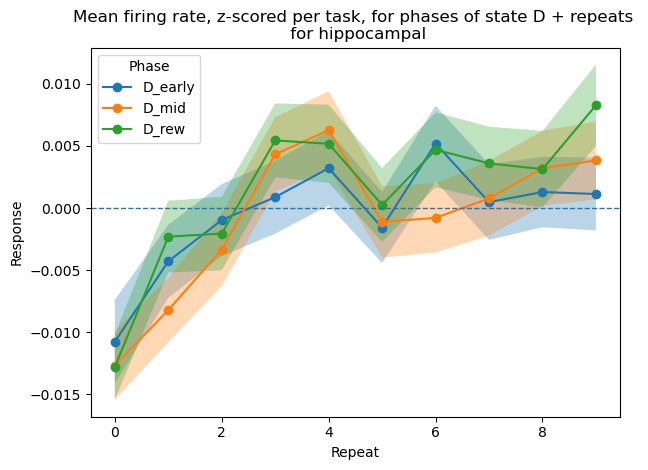

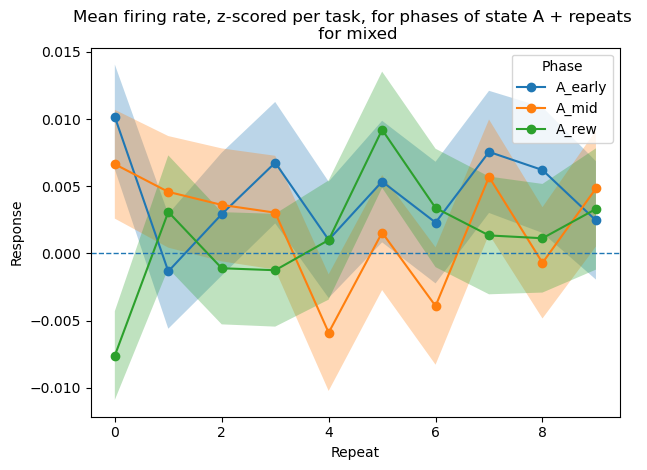

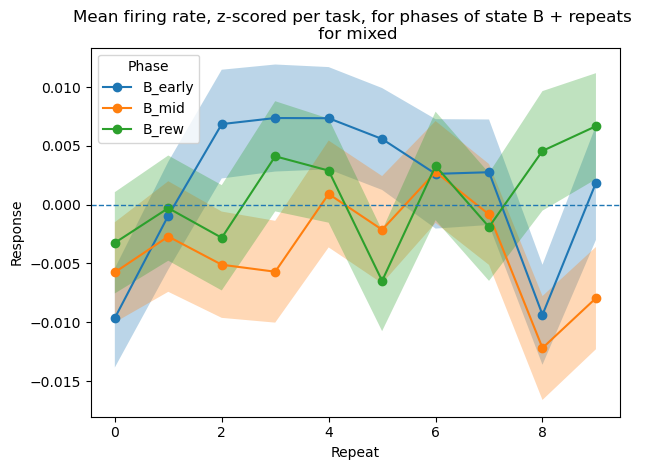

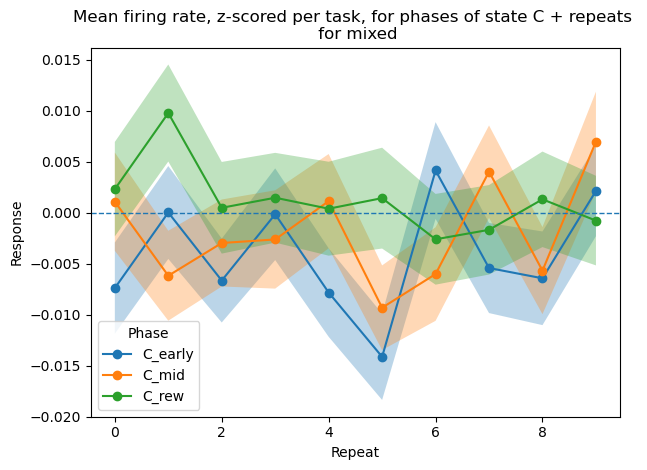

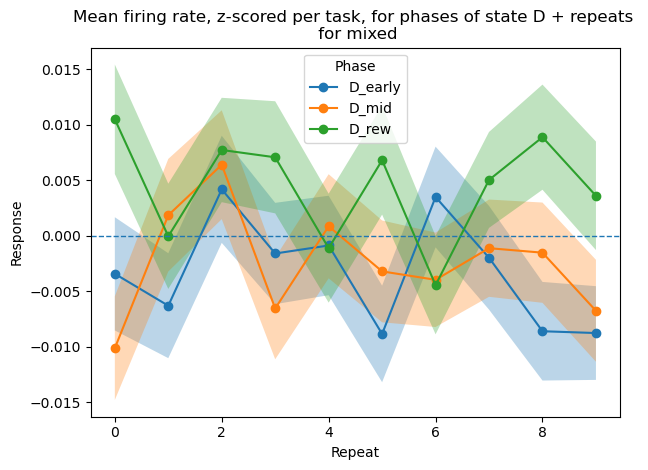

In [23]:
for roi, dn in df_ph.groupby("roi"):
    raw_mean = dn.groupby(["phase","repeat"])["y"].mean().reset_index(name="raw_mean")
    raw_sem  = dn.groupby(["phase","repeat"])["y"].sem().reset_index(name="raw_sem")
    raw = pd.merge(raw_mean, raw_sem, on=["phase","repeat"], how="left")
    for state in ['A', 'B', 'C', 'D']:
        plt.figure()
        for p in [f"{state}_early", f"{state}_mid", f"{state}_rew"]:
            r = raw [raw ["phase"]==p]
            plt.fill_between(r["repeat"], r["raw_mean"]-r["raw_sem"], r["raw_mean"]+r["raw_sem"], alpha=0.30)
            plt.plot(r["repeat"], r["raw_mean"], marker="o", label=p);
        plt.legend(title="Phase")
        plt.axhline(0, ls="--", lw=1)
        plt.title(f"Mean firing rate, z-scored per task, for phases of state {state} + repeats \n for {roi}")
        plt.xlabel("Repeat"); plt.ylabel("Response");
        plt.legend(title="Phase"); plt.tight_layout(); plt.show()    


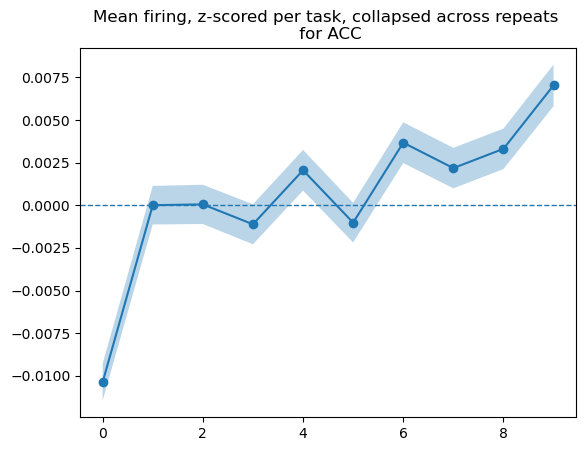

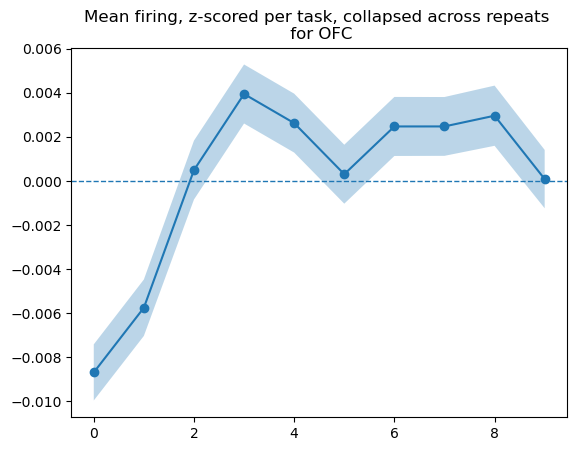

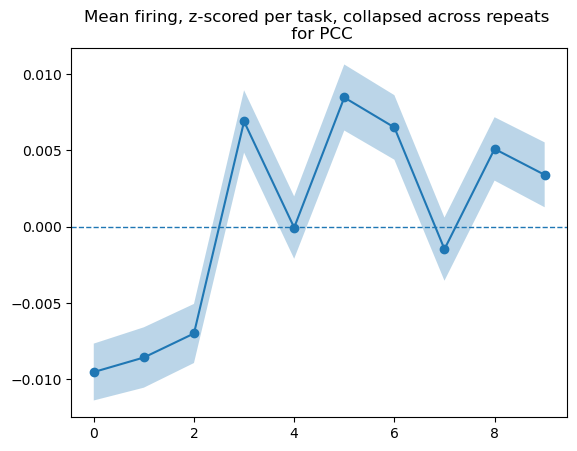

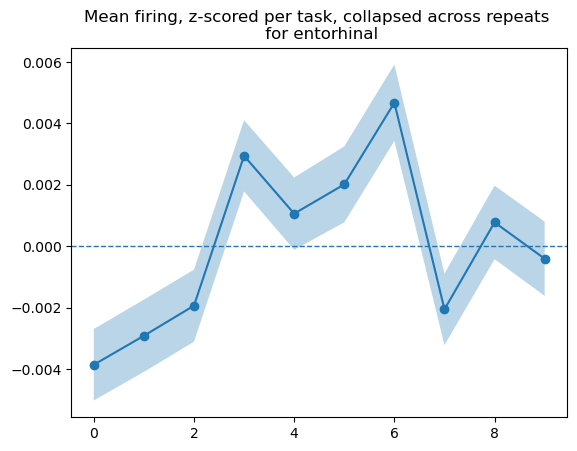

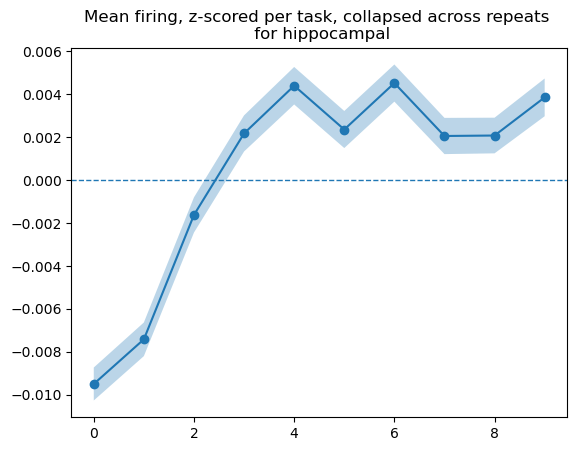

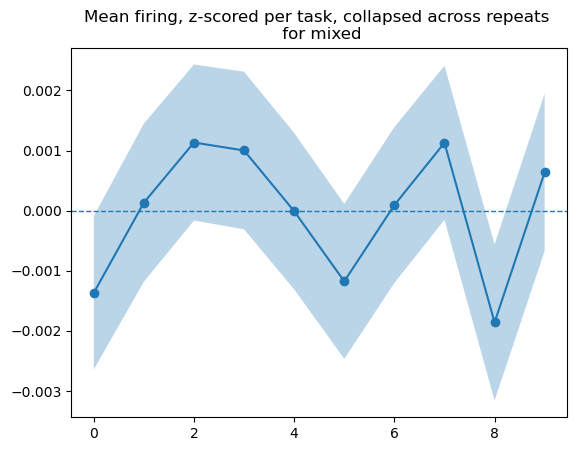

In [21]:
for roi, dn in df_ph.groupby("roi"):
    raw_mean_rep = dn.groupby(["repeat"])["y"].mean().reset_index(name="raw_mean")
    raw_sem_rep  = dn.groupby(["repeat"])["y"].sem().reset_index(name="raw_sem")
    raw_rep = pd.merge(raw_mean_rep, raw_sem_rep, on=["repeat"], how="left")
    plt.figure(); 
    plt.plot(raw_rep["repeat"], raw_rep["raw_mean"], marker="o"); 
    plt.fill_between(raw_rep["repeat"], raw_rep["raw_mean"]-raw_rep["raw_sem"], raw_rep["raw_mean"]+raw_rep["raw_sem"], alpha=0.30)
    plt.axhline(0, ls="--", lw=1)
    plt.title(f"Mean firing, z-scored per task, collapsed across repeats \n for {roi}")
   

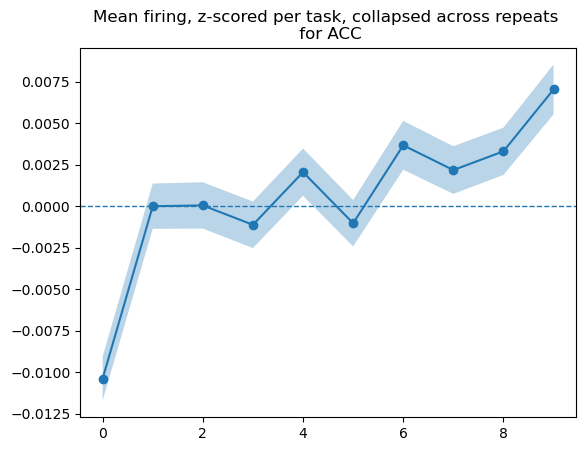

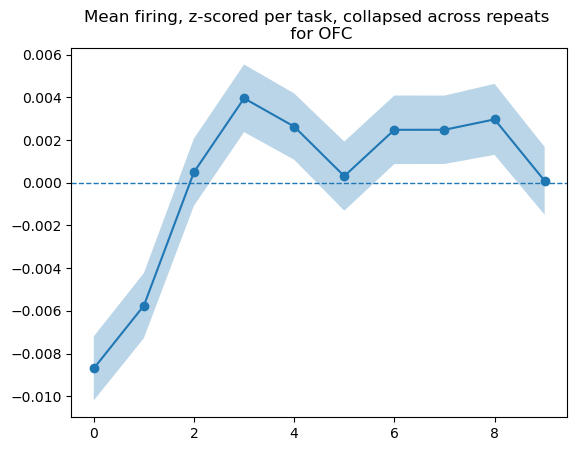

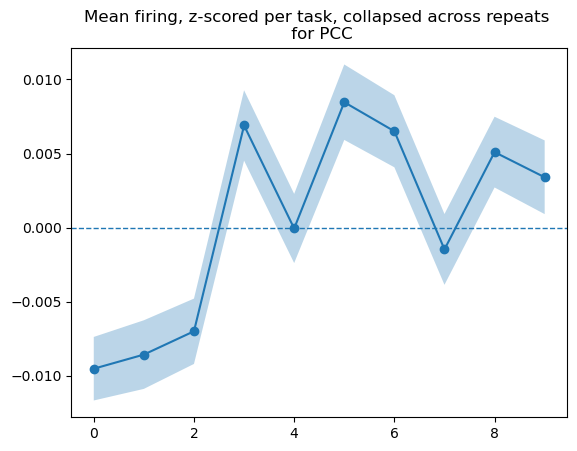

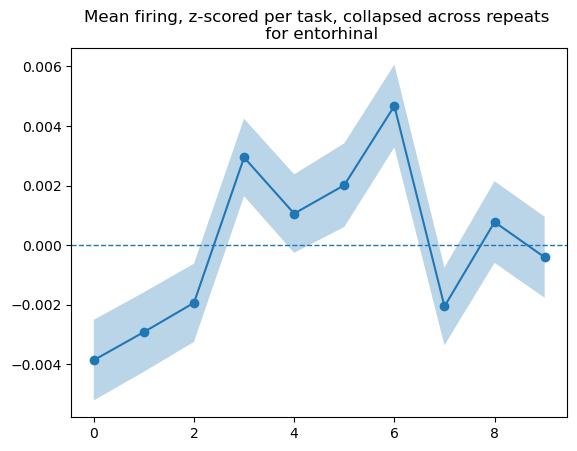

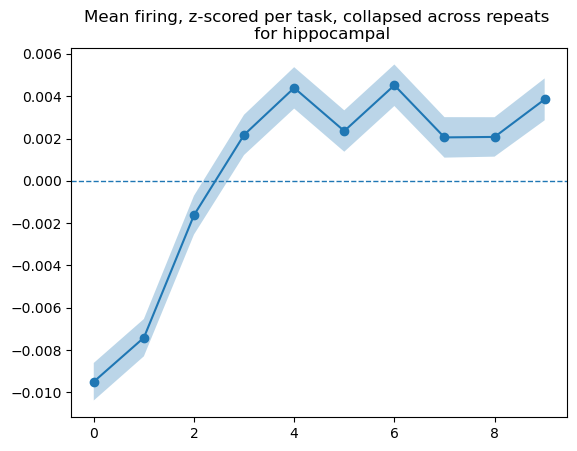

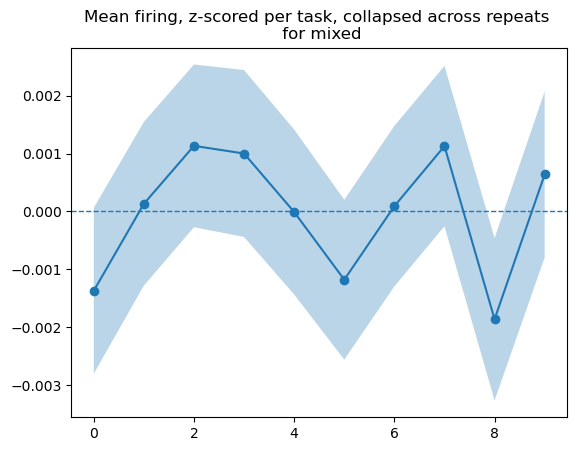

In [22]:
for roi, dn in df.groupby("roi"):
    raw_mean_rep = dn.groupby(["repeat"])["y"].mean().reset_index(name="raw_mean")
    raw_sem_rep  = dn.groupby(["repeat"])["y"].sem().reset_index(name="raw_sem")
    raw_rep = pd.merge(raw_mean_rep, raw_sem_rep, on=["repeat"], how="left")
    plt.figure(); 
    plt.plot(raw_rep["repeat"], raw_rep["raw_mean"], marker="o"); 
    plt.fill_between(raw_rep["repeat"], raw_rep["raw_mean"]-raw_rep["raw_sem"], raw_rep["raw_mean"]+raw_rep["raw_sem"], alpha=0.30)
    plt.axhline(0, ls="--", lw=1)
    plt.title(f"Mean firing, z-scored per task, collapsed across repeats \n for {roi}")
   